In [2]:
!pip install plotnine

  Using cached plotnine-0.8.0-py3-none-any.whl (4.7 MB)
  Using cached statsmodels-0.13.5-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.9 MB)
  Using cached mizani-0.7.3-py3-none-any.whl (63 kB)
  Using cached scipy-1.7.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (38.1 MB)
  Using cached descartes-1.1.0-py3-none-any.whl (5.8 kB)
  Using cached palettable-3.3.0-py2.py3-none-any.whl (111 kB)
  Using cached patsy-0.5.3-py2.py3-none-any.whl (233 kB)
  Using cached packaging-21.3-py3-none-any.whl (40 kB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: patsy
    Found existing installation: patsy 0.5.1
    Uninstalling patsy-0.5.1:
      Successfully uninstalled patsy-0.5.1
  Attempting uninstall: packaging
    Found existing installation: packaging 20.1
    Uninstalling packaging-20.1:
      Successfully uninstalled packaging-20.1
  Attem

In [29]:
import pandas as pd
import numpy as np
import collections
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import roc_auc_score
from xgboost import XGBRegressor
import plotnine
from plotnine import *
import os
import pickle
import ast
import random

In [30]:
# data format - HAIP/notebooks/op-23-models/isolation-forest/test_output_data.csv

# For Each Model:
# 1. Analysis of Outliers vs Normals for model applied to training data
# - summary statistics on outliers vs normals
# - distribution of scores by outlier group 
# - distribution /breakdown of outliers by year/quarter 
# - list of quarters/ years with outliers in them

# 2. Analysis of Outliers vs Normals for model applied to june 2022 data
# - summary statistics on outliers vs normals
# - distribution of scores by outlier group

# 3. Analysis of Outliers vs Normals for model with the mock anomaly test data 


# Analysis of Outliers vs Normals for model applied to training data
# data with: 
# actual_score | mock_score | mock_anomaly | mock_prediction
#
# - confusion matrix 



In [31]:
op10_filtered_path = "../data/OP-10-no-backfill.csv"
op10_dataset = pd.read_csv(op10_filtered_path)

In [32]:
op10_dataset

,provider_id,score,lag1,lag2,year,quarter,lag_diff,prov_mean,prov_mean_diff
0,10001,4.6,NaN,NaN,2013,2,NaN,NaN,NaN
1,10001,6.5,4.6,NaN,2014,2,1.9,4.600000,1.900000
2,10001,6.4,6.5,4.6,2015,2,-0.1,5.550000,0.850000
3,10001,9.0,6.4,6.5,2016,2,2.6,5.833333,3.166667
4,10001,6.5,9.0,6.4,2017,2,-2.5,6.625000,-0.125000
...,...,...,...,...,...,...,...,...,...
29091,670122,16.1,NaN,NaN,2018,2,NaN,NaN,NaN
29092,670122,12.6,16.1,NaN,2019,2,-3.5,16.100000,-3.500000
29093,670122,8.7,12.6,16.1,2019,4,-3.9,14.350000,-5.650000
29094,670128,5.5,NaN,NaN,2019,2,NaN,NaN,NaN


In [33]:
final_params = {
    'alpha': 0,
    'eta': 0.3,
    'gamma': 1,
    'max_depth': 6,
    'min_child_weight': 6,
    'subsample': 1}

In [38]:
xgbr_modeling_df = op10_dataset[['lag1','prov_mean','score','year','quarter']]

xgbr_modeling_df = xgbr_modeling_df[~((xgbr_modeling_df['year'] == 2019) & (xgbr_modeling_df['quarter'] == 4))].dropna()
xgbr_modeling_df = xgbr_modeling_df.drop(columns = ['year','quarter'])
xgbr_modeling_df

,lag1,prov_mean,score
1,4.6,4.600000,6.5
2,6.5,5.550000,6.4
3,6.4,5.833333,9.0
4,9.0,6.625000,6.5
5,6.5,6.600000,8.0
...,...,...,...
29082,0.8,1.000000,0.2
29086,69.2,69.200000,63.2
29088,1.7,1.700000,6.6
29089,6.6,4.150000,7.5


In [131]:
model = XGBRegressor(**final_params)
X, y = xgbr_modeling_df[['lag1','prov_mean']], xgbr_modeling_df[['score']]
model.fit(X, y)
predicted_score = model.predict(op10_dataset[['lag1','prov_mean']].dropna())
outlier_prediction = (abs(op10_dataset[['lag1','prov_mean','score']].dropna()['score'] - predicted_score) > 5)
outlier_prediction

1        False
2        False
3        False
4        False
5        False
         ...  
29089    False
29090     True
29092    False
29093    False
29095    False
Name: score, Length: 24799, dtype: bool

In [132]:
np.mean(abs(op10_dataset[['lag1','prov_mean','score']].dropna()['score'] - predicted_score))

2.375336415859772

In [133]:
final_op10_dataset = op10_dataset.copy()
final_op10_dataset = final_op10_dataset[final_op10_dataset['lag1'].notna()]
final_op10_dataset['outlier'] = outlier_prediction
final_op10_dataset['predicted_score'] = predicted_score
final_op10_dataset['diff'] = final_op10_dataset['score'] - final_op10_dataset['predicted_score']
final_op10_dataset['lag1_diff'] = final_op10_dataset['score'] - final_op10_dataset['lag1']
final_op10_dataset['y_quarter'] = final_op10_dataset['year'].astype(str) + 'Q' + final_op10_dataset['quarter'].astype(str)

In [134]:
final_op10_dataset[final_op10_dataset['y_quarter'] == '2019Q4']['outlier'].value_counts()

False    2137
True      968
Name: outlier, dtype: int64

In [135]:
final_op10_dataset['outlier'].value_counts()

False    21906
True      2893
Name: outlier, dtype: int64

In [136]:
plotnine.options.figure_size = (12,8)

In [119]:
final_op10_dataset[final_op10_dataset['outlier'] == True]

,provider_id,score,lag1,lag2,year,quarter,lag_diff,prov_mean,prov_mean_diff,outlier,predicted_score,diff,lag1_diff,y_quarter
7,10001,1.1,7.2,8.0,2019,4,-6.1,6.885714,-5.785714,True,6.860431,-5.760431,-6.1,2019Q4
11,10005,16.1,13.3,11.9,2016,2,2.8,12.533333,3.566667,True,11.641703,4.458297,2.8,2016Q2
15,10005,5.0,14.2,12.9,2019,4,-9.2,13.671429,-8.671429,True,11.989609,-6.989609,-9.2,2019Q4
23,10006,4.4,14.5,14.2,2019,4,-10.1,12.714286,-8.314286,True,12.412149,-8.012149,-10.1,2019Q4
31,10007,1.1,9.1,10.2,2019,4,-8.0,19.114286,-18.014286,True,8.332046,-7.232046,-8.0,2019Q4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29062,670098,1.9,9.2,8.5,2019,4,-7.3,6.340000,-4.440000,True,7.691446,-5.791446,-7.3,2019Q4
29068,670106,13.8,5.7,NaN,2017,2,8.1,5.700000,8.100000,True,5.762344,8.037656,8.1,2017Q2
29088,670120,6.6,1.7,NaN,2018,2,4.9,1.700000,4.900000,True,2.250117,4.349883,4.9,2018Q2
29090,670120,1.6,7.5,6.6,2019,4,-5.9,5.266667,-3.666667,True,6.798064,-5.198064,-5.9,2019Q4


In [120]:
final_op10_dataset.describe()

,provider_id,score,lag1,lag2,year,quarter,lag_diff,prov_mean,prov_mean_diff,predicted_score,diff,lag1_diff
count,24799.000000,24799.000000,24799.000000,20675.000000,24799.000000,24799.000000,24799.000000,24799.000000,24799.000000,24799.000000,24799.000000,24799.000000
mean,263954.500867,7.413763,8.661273,8.976958,2016.850034,2.250413,-1.247510,9.732317,-2.318554,7.956612,-0.542896,-1.247510
std,154103.572163,8.414690,9.470437,9.815834,1.798227,0.661920,4.511939,10.353490,6.122558,7.594636,3.580129,4.511939
min,10001.000000,0.100000,0.100000,0.100000,2014.000000,2.000000,-75.400000,0.100000,-75.400000,-0.532946,-32.734616,-75.400000
25%,140125.000000,2.700000,3.400000,3.500000,2015.000000,2.000000,-2.500000,3.780000,-3.500000,3.836720,-2.011739,-2.500000
50%,250102.000000,5.100000,5.900000,6.000000,2017.000000,2.000000,-0.500000,6.300000,-1.000000,5.897326,-0.507200,-0.500000
75%,390058.000000,8.800000,10.000000,10.300000,2019.000000,2.000000,0.800000,11.250000,0.550000,8.949583,0.956864,0.800000
max,670128.000000,92.000000,96.400000,96.400000,2019.000000,4.000000,44.600000,96.400000,44.600000,82.562752,43.424303,44.600000


In [121]:
final_op10_dataset[['outlier', 'score']]\
    .groupby('outlier')\
    .describe(percentiles = [.01, .1, .25, .5, .75, .9, .99])\
    .transpose()

outlier             False         True
score count  20538.000000  4261.000000
      mean       6.417597    12.215278
      std        6.580632    13.250093
      min        0.100000     0.200000
      1%         0.300000     0.500000
      10%        1.300000     1.300000
      25%        2.700000     2.500000
      50%        4.900000     7.700000
      75%        7.900000    17.000000
      90%       12.400000    30.200000
      99%       34.200000    60.940000
      max       82.900000    92.000000

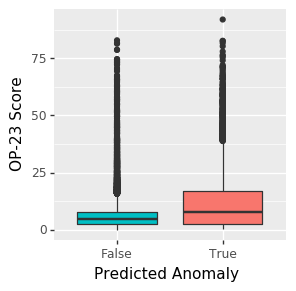

<ggplot: (8773031563345)>

In [122]:
plotnine.options.figure_size = (3,3)
(ggplot(final_op10_dataset,     
        aes(x = 'outlier',
            y = 'score',
            fill = 'outlier')) +
    ylab("OP-23 Score") +
    xlab("Predicted Anomaly") +
    labs(fill = 'Predicted Anomaly') +
    geom_boxplot(show_legend = False) +
    scale_fill_manual(values = ["#00BFC4", "#F8766D"])
    
)

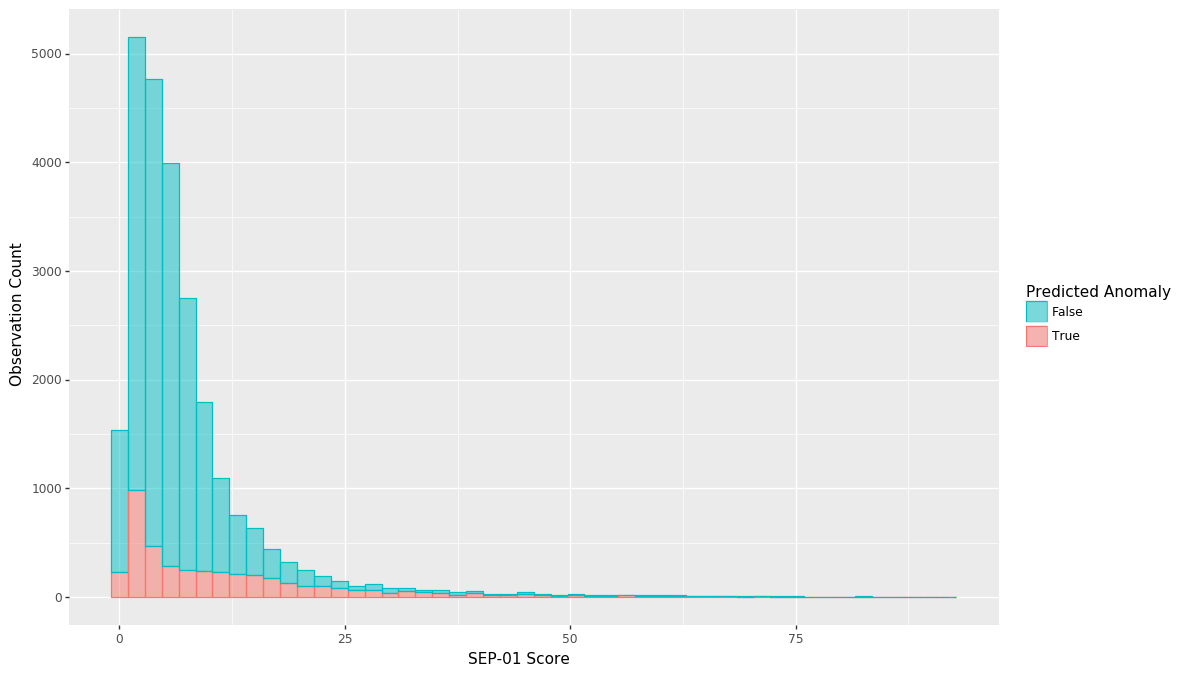

<ggplot: (8773037382045)>

In [124]:
plotnine.options.figure_size = (12,8)
(ggplot(final_op10_dataset,     
        aes(x = 'score',
            color = 'outlier',
            fill = 'outlier')) +
    xlab("SEP-01 Score") +
    ylab("Observation Count") +
    labs(fill = 'Predicted Anomaly', color = 'Predicted Anomaly') +
    scale_color_manual(values = ["#00BFC4", "#F8766D"]) +
    scale_fill_manual(values = ["#00BFC4", "#F8766D"]) +
    geom_histogram(bins = 50, alpha = 0.5)  
)

In [125]:
## THIS GRAPH

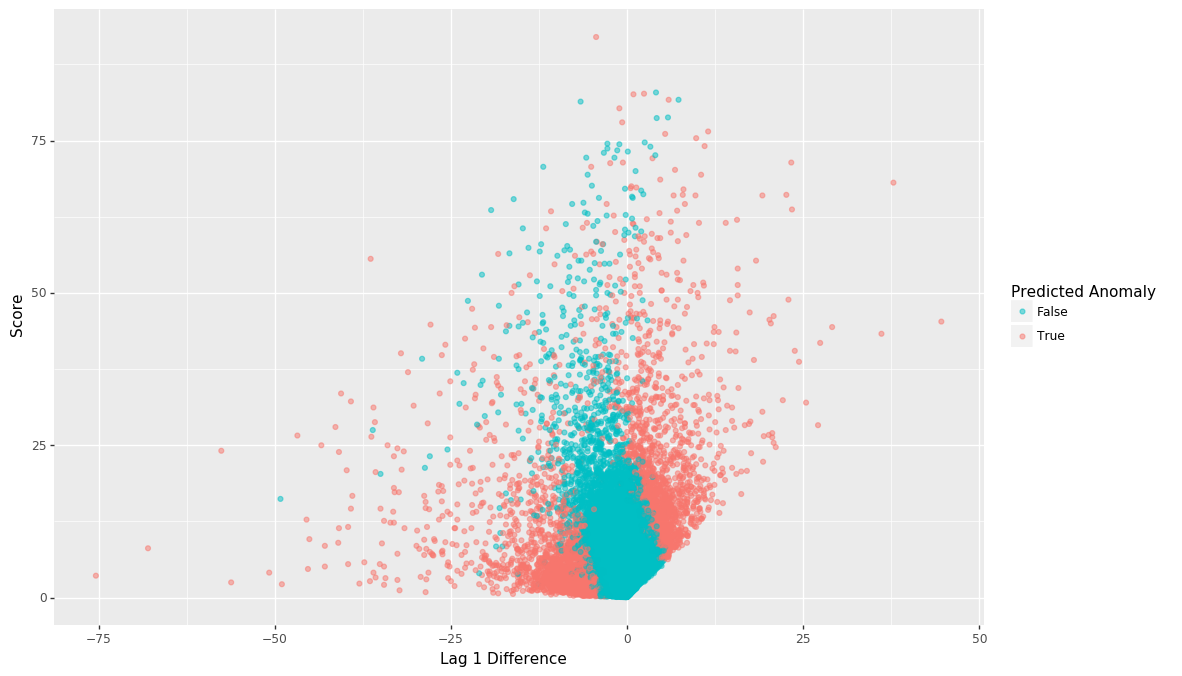

<ggplot: (8773055317901)>

In [126]:
plotnine.options.figure_size = (12,8)
(ggplot(final_op10_dataset,     
        aes(x = 'lag1_diff', 
            y = 'score',
            color = 'outlier',
            fill = 'outlier')) +
    xlab("Lag 1 Difference") +
    ylab("Score") +
    labs(fill = 'Predicted Anomaly', color = 'Predicted Anomaly') +
    scale_color_manual(values = ["#00BFC4", "#F8766D"]) +
    scale_fill_manual(values = ["#00BFC4", "#F8766D"]) +
    geom_point(alpha = 0.5)
)

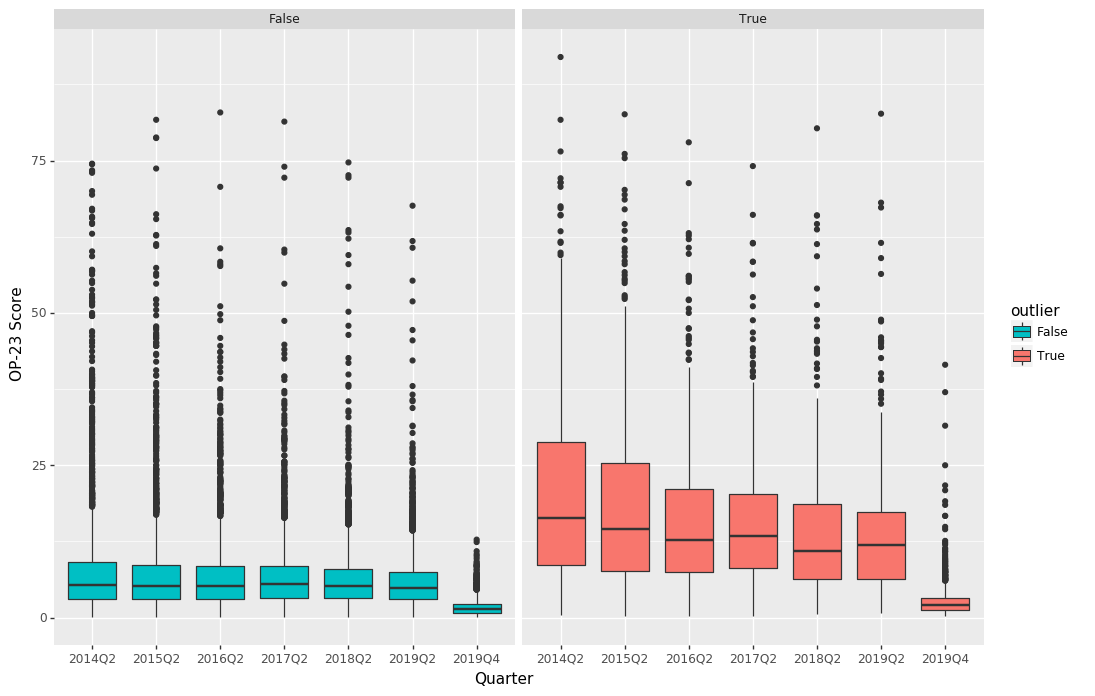

<ggplot: (8773055036545)>

In [127]:
(ggplot(final_op10_dataset,     
        aes(x = 'y_quarter',
            y = 'score',
            fill = 'outlier')) +
    ylab("OP-23 Score") +
    xlab("Quarter") +
    geom_boxplot() +
    scale_fill_manual(values = ["#00BFC4", "#F8766D"]) +
    facet_wrap('~outlier')
    
)

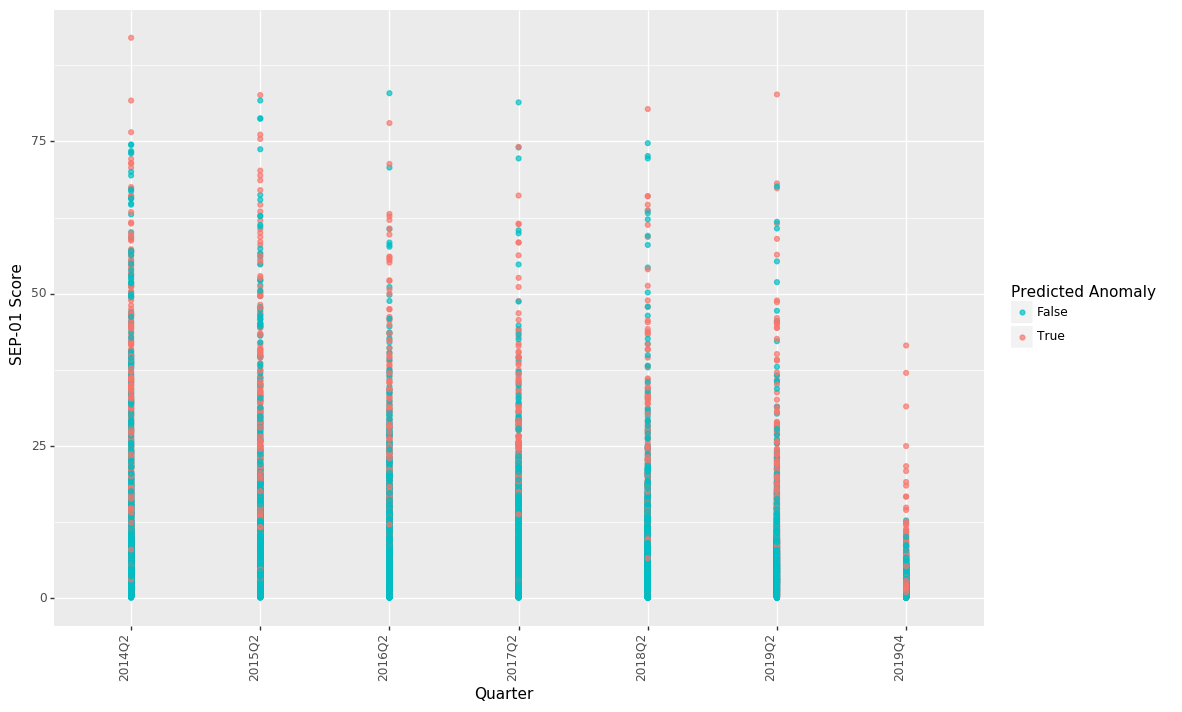

<ggplot: (8773054996149)>

In [128]:
(ggplot(final_op10_dataset,     
        aes(x = 'y_quarter',
            y = 'score',
            fill = 'outlier',
            color = 'outlier')) +
    ylab("SEP-01 Score") +
    xlab("Quarter") +
    geom_point(alpha = 0.7) +
    labs(fill = 'Predicted Anomaly', color = 'Predicted Anomaly') +
    scale_fill_manual(values = ["#00BFC4", "#F8766D"]) +
    scale_color_manual(values = ["#00BFC4", "#F8766D"]) +
    theme(axis_text_x=element_text(rotation=90, hjust=1))
)

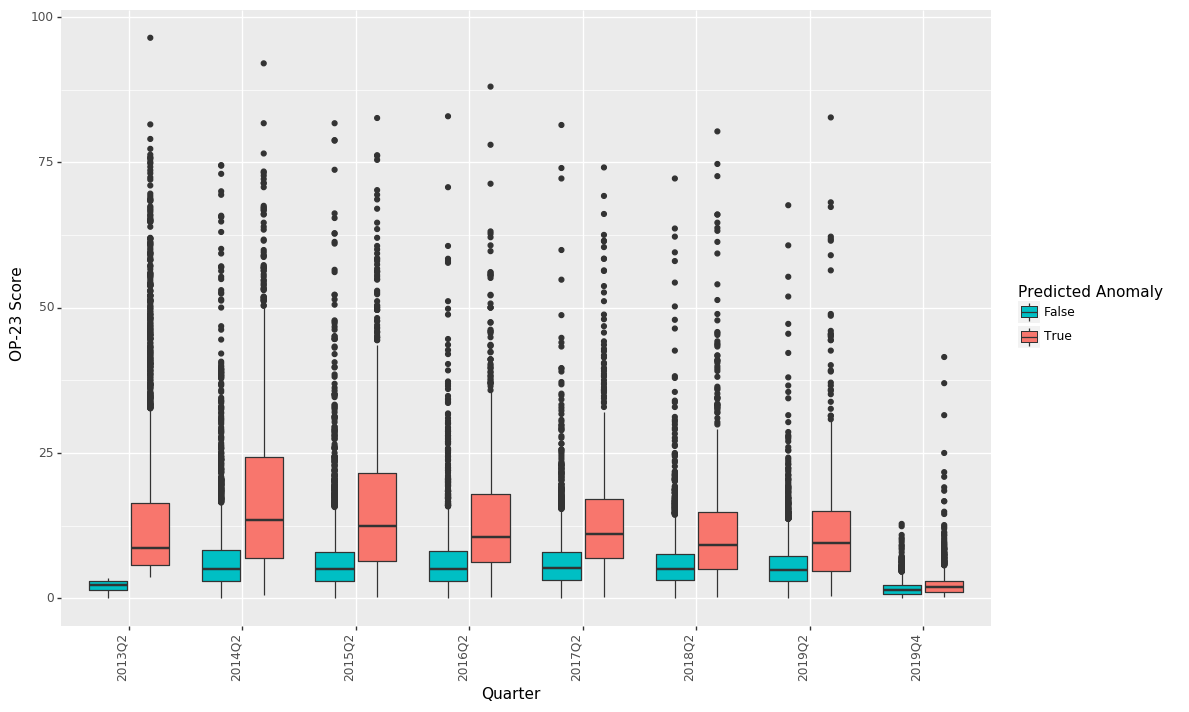

<ggplot: (8773055190753)>

In [54]:
(ggplot(final_op10_dataset,     
        aes(x = 'y_quarter',
            y = 'score',
            fill = 'outlier')) +
    ylab("OP-23 Score") +
    xlab("Quarter") +
    geom_boxplot() +
    labs(fill = 'Predicted Anomaly') +
    scale_fill_manual(values = ["#00BFC4", "#F8766D"]) +
    theme(axis_text_x=element_text(rotation=90, hjust=1))
    #facet_wrap('~outlier')
)

In [ ]:
## USE THIS GRAPH

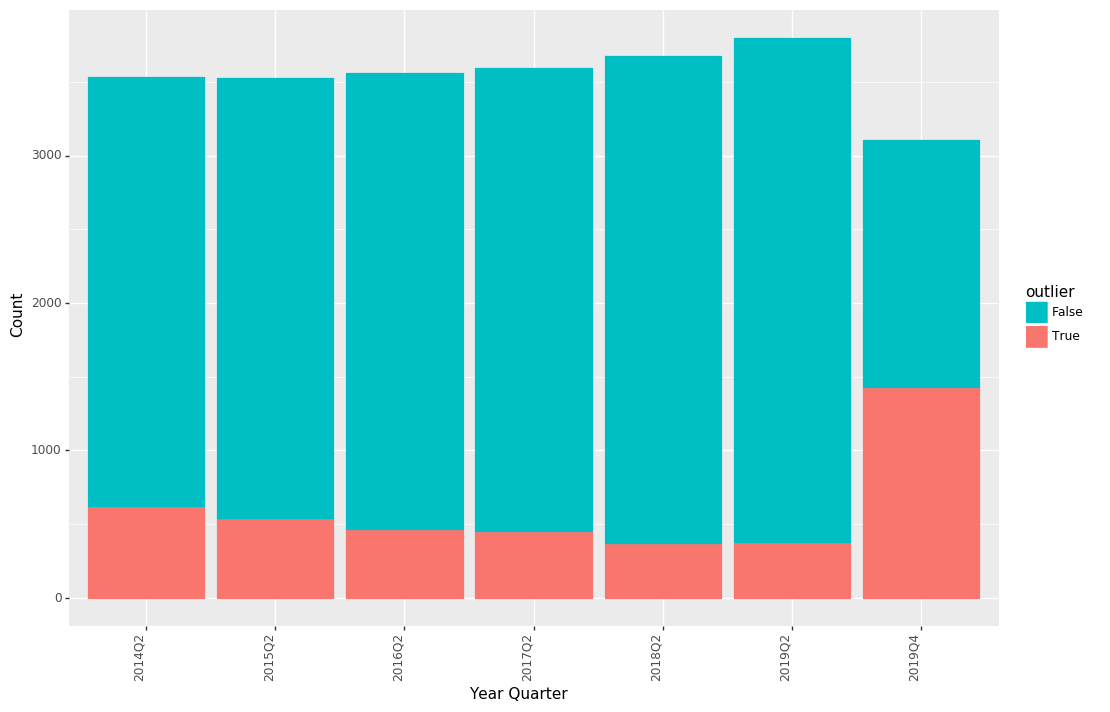

<ggplot: (8773054962661)>

In [129]:
(ggplot(final_op10_dataset,     
        aes(x = 'y_quarter',
            color = 'outlier',
            fill = 'outlier')) + 
    xlab("Year Quarter") +
    ylab("Count") +
    scale_color_manual(values = ["#00BFC4", "#F8766D"]) +
    scale_fill_manual(values = ["#00BFC4", "#F8766D"]) +
    geom_bar() +
    theme(axis_text_x=element_text(rotation=90, hjust=1))
)

In [137]:
summary_table = pd.DataFrame({"outlier count": final_op10_dataset.loc[ final_op10_dataset['outlier'] == True, 'y_quarter'].value_counts(),
                              "total": final_op10_dataset['y_quarter'].value_counts()})
summary_table['% outlier'] = summary_table["outlier count"] / summary_table["total"]
summary_table['% outlier'] = round(summary_table['% outlier']*100,2)
summary_table

,outlier count,total,% outlier
2014Q2,453,3531,12.83
2015Q2,376,3527,10.66
2016Q2,317,3560,8.90
2017Q2,289,3598,8.03
2018Q2,251,3678,6.82
2019Q2,239,3800,6.29
2019Q4,968,3105,31.18


In [138]:
final_op10_dataset.loc[(final_op10_dataset['y_quarter'] == '2021Q3') & (final_op10_dataset['outlier'] == True)]

,provider_id,score,lag1,lag2,year,quarter,lag_diff,prov_mean,prov_mean_diff,outlier,predicted_score,diff,lag1_diff,y_quarter


In [130]:
june_22_outliers = final_op10_dataset.loc[(final_op10_dataset['y_quarter'] == '2021Q3') & (final_op10_dataset['outlier'] == True), 'providerId']
june_22_outliers

201       10034
282       10044
396       10061
492       10086
1021      21311
          ...  
41663    521341
41692    521349
41831    530025
42086    670068
42284    670124
Name: providerId, Length: 113, dtype: int64

In [131]:
june_22_scores = (final_op10_dataset[(final_op10_dataset['y_quarter'] == '2021Q3') 
                                       & (final_op10_dataset['outlier'] == True)])
june_22_scores = june_22_scores[['providerId','score']].rename(columns = {'score':'score_2021Q3'})                                                            
june_22_scores

,providerId,score_2021Q3
201,10034,31
282,10044,57
396,10061,35
492,10086,42
1021,21311,38
...,...,...
41663,521341,71
41692,521349,71
41831,530025,69
42086,670068,66


In [132]:
june_22_providers_df = final_op10_dataset[final_op10_dataset['providerId'].isin(june_22_outliers)]
june_22_providers_df

,providerId,score,y_quarter,lag1,lag2,year,quarter,outlier,predicted_score,diff,lag1_diff
191,10034,25,2017Q3,25.0,25.0,2017,3,False,25.325060,-0.325060,0.0
192,10034,32,2017Q4,25.0,25.0,2017,4,False,26.857748,5.142252,7.0
193,10034,40,2018Q1,32.0,25.0,2018,1,False,34.511860,5.488140,8.0
194,10034,60,2018Q2,40.0,32.0,2018,2,True,42.246067,17.753933,20.0
195,10034,68,2018Q3,60.0,40.0,2018,3,False,61.669552,6.330448,8.0
...,...,...,...,...,...,...,...,...,...,...,...
42280,670124,50,2019Q1,64.0,64.0,2019,1,False,64.590469,-14.590469,-14.0
42281,670124,38,2019Q2,50.0,64.0,2019,2,False,51.511978,-13.511978,-12.0
42282,670124,19,2019Q3,38.0,50.0,2019,3,True,39.971443,-20.971443,-19.0
42283,670124,14,2019Q4,19.0,38.0,2019,4,False,20.825752,-6.825752,-5.0


In [133]:
june_22_prov_means = (
    june_22_providers_df[june_22_providers_df['y_quarter'] != '2021Q3']
    .groupby('providerId')['score']
    .mean()
    .reset_index()
    .rename(columns = {'score':'prov_mean_score'})
)
june_22_prov_means

,providerId,provider_mean_score
0,10034,58.600000
1,10044,68.545455
2,10061,42.000000
3,10086,57.000000
4,21311,38.538462
...,...,...
108,521341,54.000000
109,521349,75.916667
110,530025,45.307692
111,670068,56.230769


In [134]:
june_22_providers_df = (june_22_providers_df
                        .merge(june_22_prov_means, how = 'left', on = 'providerId')
                        .merge(june_22_scores, how = 'left', on = 'providerId'))
june_22_providers_df['prov_mean_diff'] = june_22_providers_df['score'] - june_22_providers_df['prov_mean_score']
june_22_providers_df

,providerId,score,y_quarter,lag1,lag2,year,quarter,outlier,predicted_score,diff,lag1_diff,provider_mean_score,score_2021Q3
0,10034,25,2017Q3,25.0,25.0,2017,3,False,25.325060,-0.325060,0.0,58.6,31
1,10034,32,2017Q4,25.0,25.0,2017,4,False,26.857748,5.142252,7.0,58.6,31
2,10034,40,2018Q1,32.0,25.0,2018,1,False,34.511860,5.488140,8.0,58.6,31
3,10034,60,2018Q2,40.0,32.0,2018,2,True,42.246067,17.753933,20.0,58.6,31
4,10034,68,2018Q3,60.0,40.0,2018,3,False,61.669552,6.330448,8.0,58.6,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1351,670124,50,2019Q1,64.0,64.0,2019,1,False,64.590469,-14.590469,-14.0,37.0,65
1352,670124,38,2019Q2,50.0,64.0,2019,2,False,51.511978,-13.511978,-12.0,37.0,65
1353,670124,19,2019Q3,38.0,50.0,2019,3,True,39.971443,-20.971443,-19.0,37.0,65
1354,670124,14,2019Q4,19.0,38.0,2019,4,False,20.825752,-6.825752,-5.0,37.0,65


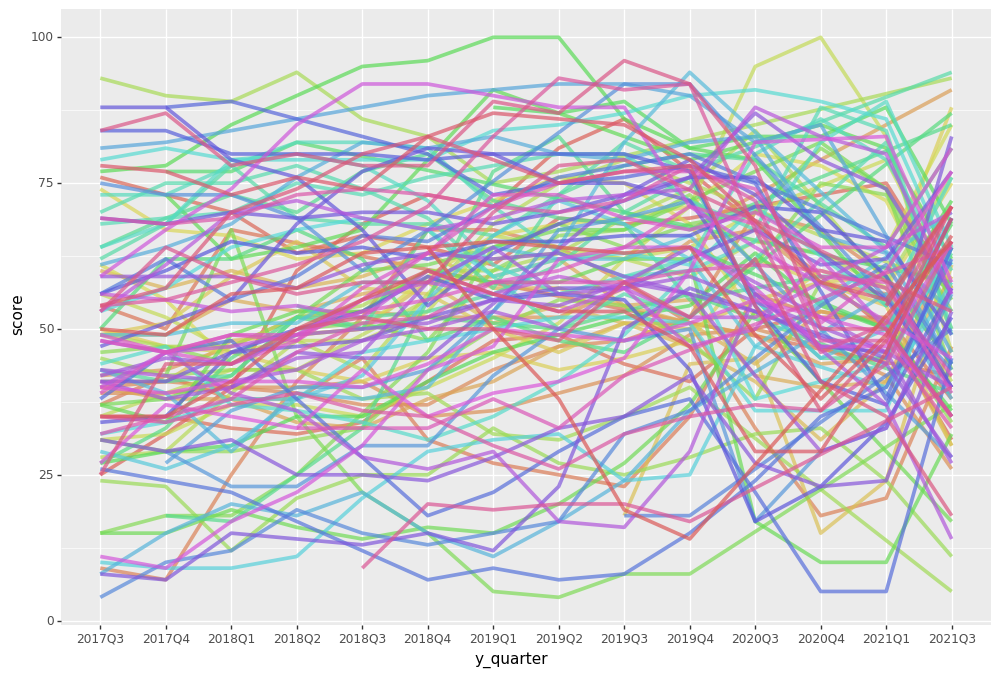

<ggplot: (8751951113245)>

In [87]:
(ggplot(june_22_providers_df,
        aes(x = 'y_quarter',
            y = 'score',
            group = 'factor(providerId)',
            color = 'factor(providerId)')) +
 geom_line(size = 1.5, show_legend=False, alpha = 0.7)
)

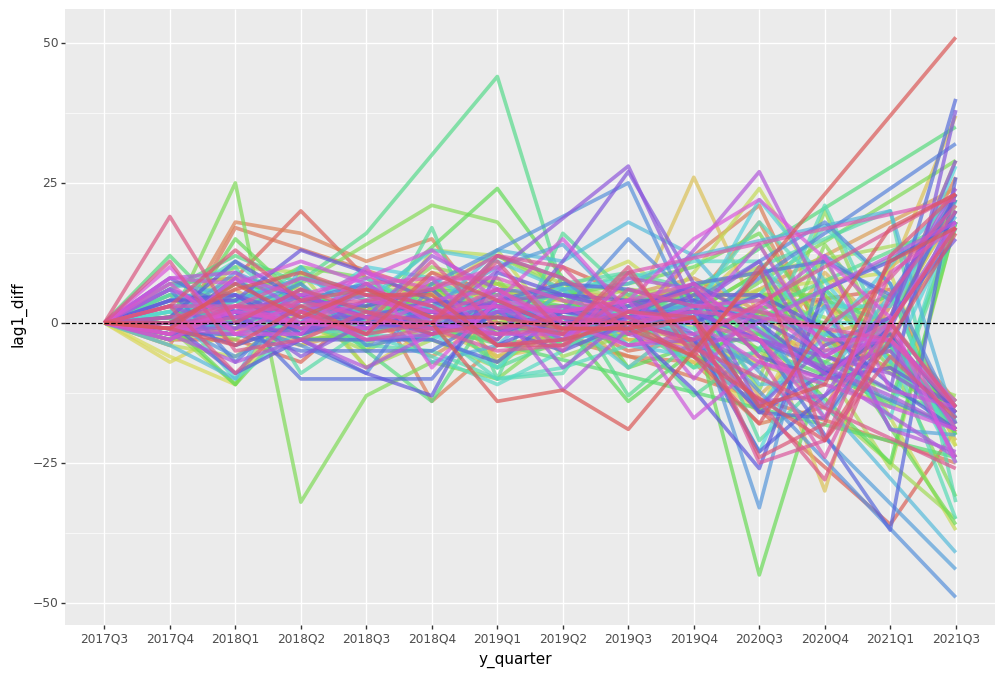

<ggplot: (8751965095789)>

In [84]:
(ggplot(june_22_providers_df,
        aes(x = 'y_quarter',
            y = 'lag1_diff',
            group = 'factor(providerId)',
            color = 'factor(providerId)')) +
 geom_line(size = 1.5, show_legend=False, alpha = 0.7) +
 geom_hline(yintercept = 0, linetype = 'dashed')
)

/opt/conda/lib/python3.7/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


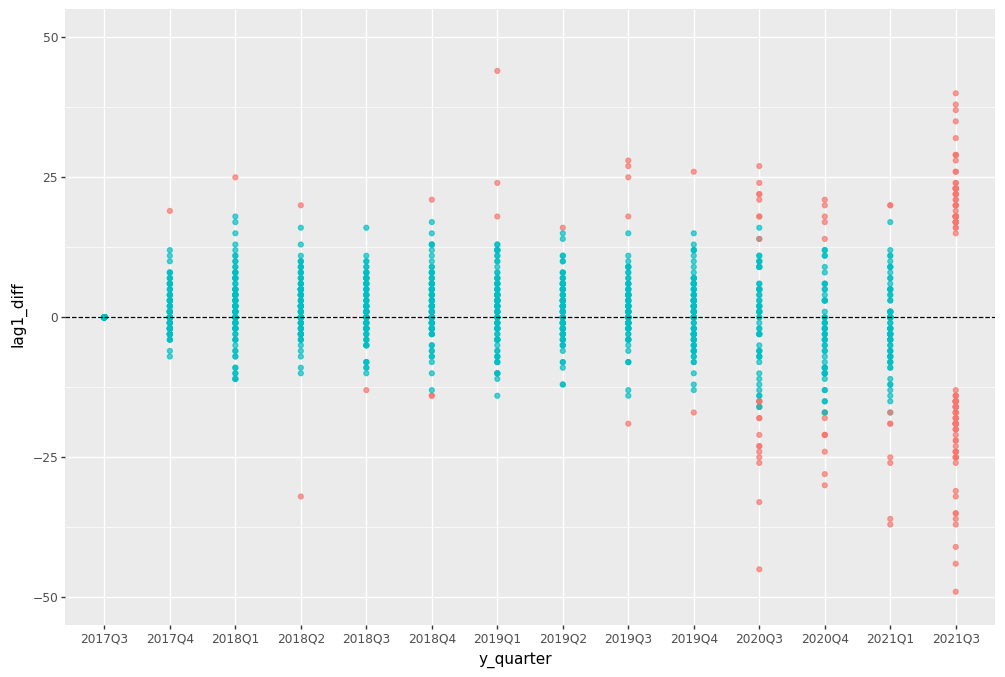

<ggplot: (8751965239305)>

In [191]:
plotnine.options.figure_size = (12,8)
(ggplot(june_22_providers_df,
        aes(x = 'y_quarter',
            y = 'lag1_diff',
            color = 'outlier')) +
 geom_point(size = 1.5, show_legend=False, alpha = 0.7) +
 labs(fill = 'Predicted Anomaly', color = 'Predicted Anomaly') +
 scale_color_manual(values = ["#00BFC4", "#F8766D"]) +
 ylim(-50,50) + 
 geom_hline(yintercept = 0, linetype = 'dashed')
)

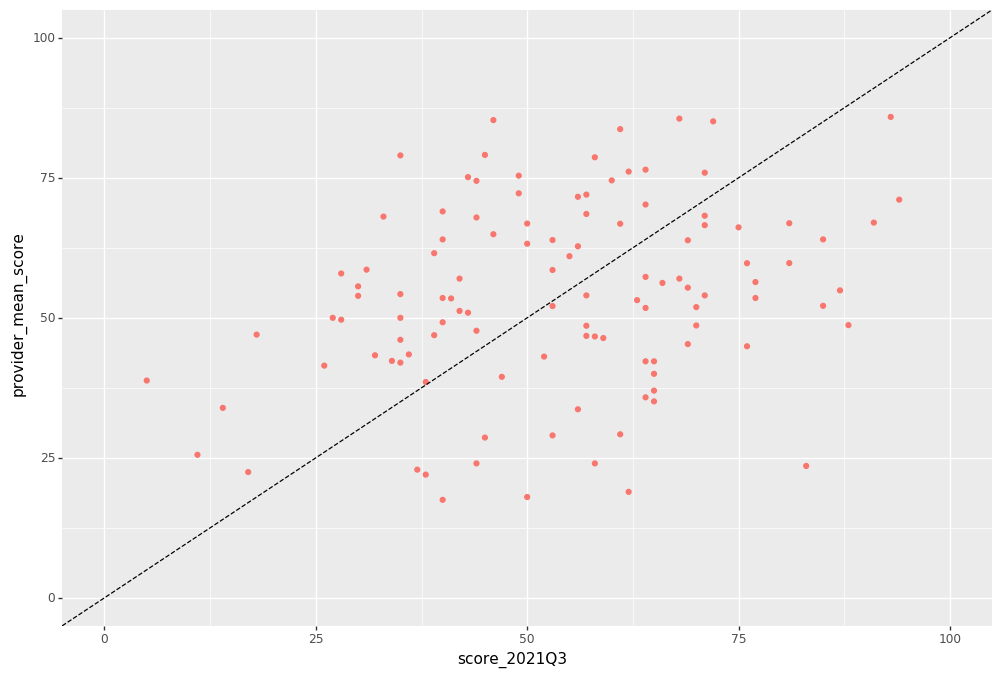

<ggplot: (8751951093593)>

In [175]:
(ggplot(june_22_providers_df[june_22_providers_df['y_quarter'] == '2021Q3'],
        aes(x = 'score_2021Q3',
            y = 'prov_mean_score')) +
 geom_point(size = 1.5, 
            show_legend=False,
            color = '#F8766D') +
 xlim(0,100) +
 ylim(0,100) +
 geom_abline(intercept = 0, slope = 1, linetype = 'dashed')
)

/opt/conda/lib/python3.7/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 61 rows containing missing values.


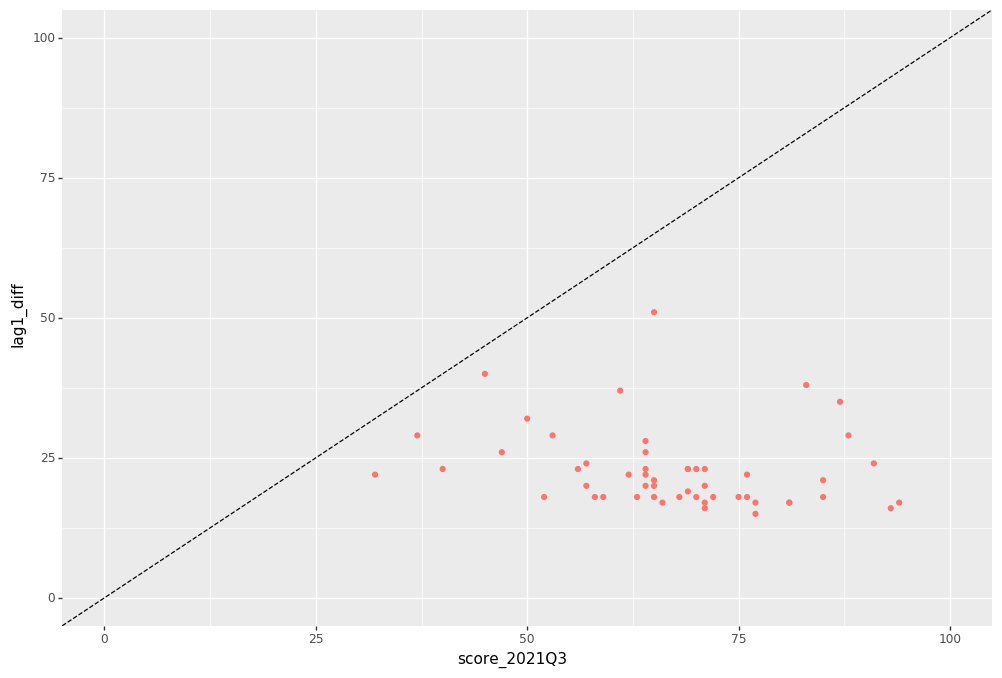

<ggplot: (8751949651981)>

In [174]:
(ggplot(june_22_providers_df[june_22_providers_df['y_quarter'] == '2021Q3'],
        aes(x = 'score_2021Q3',
            y = 'lag1_diff')) +
 geom_point(size = 1.5, 
            show_legend=False,
            color = '#F8766D') +
 xlim(0,100) +
 ylim(0,100) +
 geom_abline(intercept = 0, slope = 1, linetype = 'dashed')
)

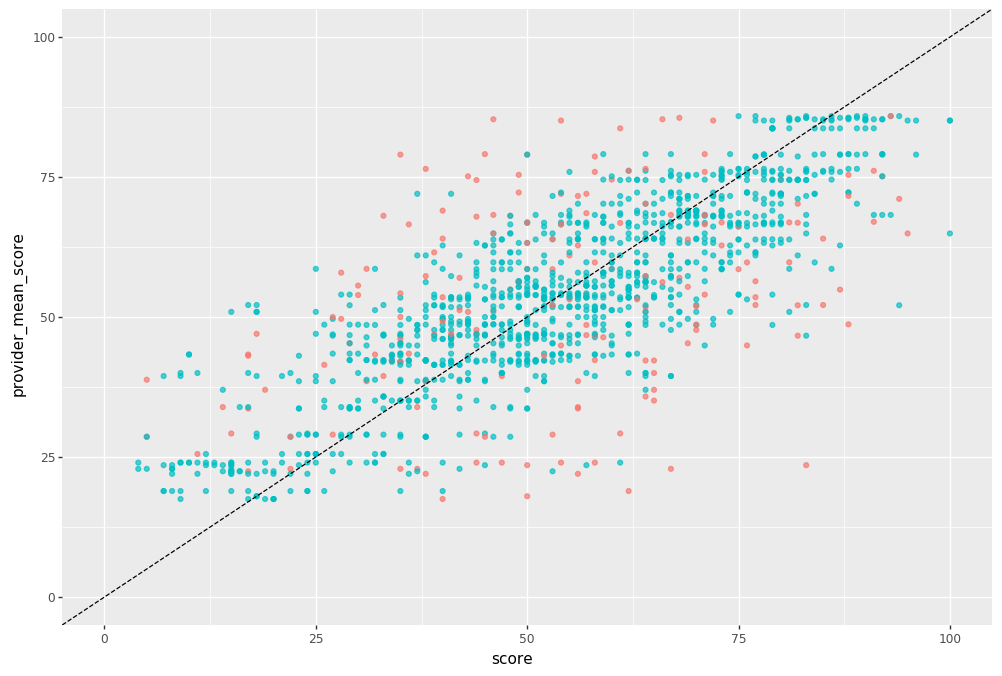

<ggplot: (8751965275329)>

In [128]:
(ggplot(june_22_providers_df,
        aes(x = 'score',
            y = 'prov_mean_score',
            color = 'outlier')) +
 geom_point(size = 1.5, show_legend=False, alpha = 0.7) +
 xlim(0,100) +
 ylim(0,100) +
 labs(fill = 'Predicted Anomaly', color = 'Predicted Anomaly') +
 scale_color_manual(values = ["#00BFC4", "#F8766D"]) +
 geom_abline(intercept = 0, slope = 1, linetype = 'dashed')
)

/opt/conda/lib/python3.7/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 664 rows containing missing values.


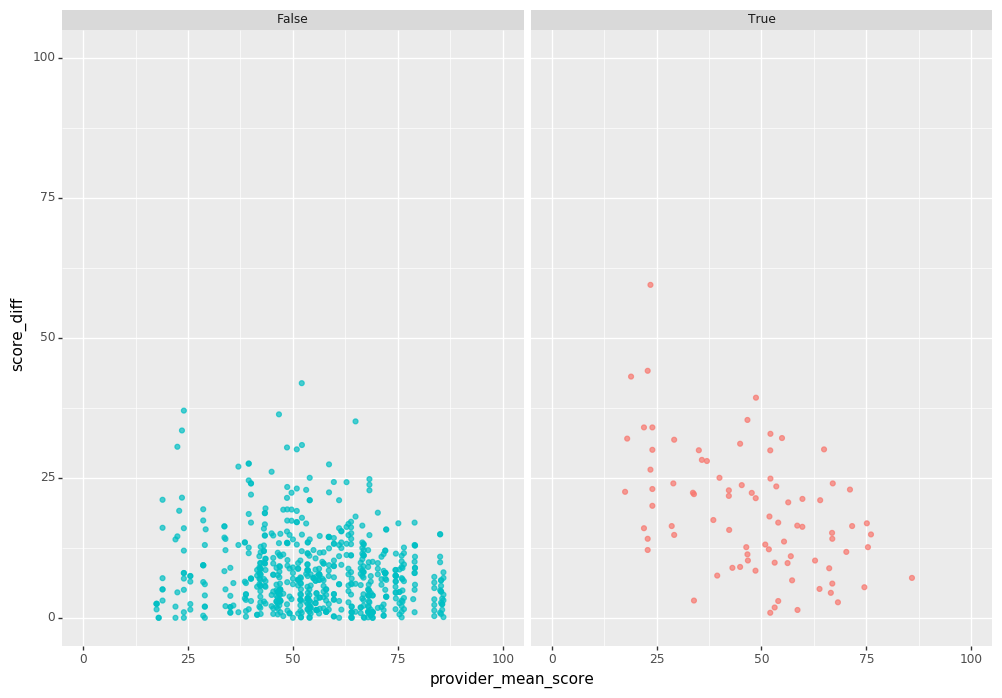

<ggplot: (8751964778969)>

In [162]:
(ggplot(june_22_providers_df,
        aes(x = 'prov_mean_score',
            y = 'prov_mean_diff',
            color = 'outlier')) +
 geom_point(size = 1.5, show_legend=False, alpha = 0.7) +
 xlim(0,100) +
 ylim(0,100) +
 labs(fill = 'Predicted Anomaly', color = 'Predicted Anomaly') +
 scale_color_manual(values = ["#00BFC4", "#F8766D"]) +
 facet_wrap('~outlier')
)

In [155]:
(ggplot(june_22_providers_df,
        aes(x = 'lag1_diff',
            y = 'prov_mean_diff',
            color = 'outlier')) +
 geom_point(size = 1.5, show_legend=False, alpha = 0.7) +
 xlim(0,100) +
 ylim(0,100) +
 labs(fill = 'Predicted Anomaly', color = 'Predicted Anomaly') +
 scale_color_manual(values = ["#00BFC4", "#F8766D"]) +
 facet_wrap('~outlier')
)

NameError: name 'june_22_providers_df' is not defined

In [41]:
prov_means = (
    final_op10_dataset
    .groupby('providerId')['score']
    .mean()
    .reset_index()
    .rename(columns = {'score':'prov_mean_score'})
)
prov_means

,providerId,provider_mean_score
0,10001,59.142857
1,10005,65.571429
2,10006,31.428571
3,10007,91.571429
4,10008,36.333333
...,...,...
3240,670120,61.071429
3241,670122,81.214286
3242,670124,41.666667
3243,670128,79.500000


In [176]:
final_op10_dataset['prov_diff_abs']  = abs(final_op10_dataset['prov_mean_diff'])
final_op10_dataset['lag_diff_abs']  = abs(final_op10_dataset['lag_diff'])

In [177]:
final_op10_dataset

,provider_id,score,lag1,lag2,year,quarter,lag_diff,prov_mean,prov_mean_diff,outlier,predicted_score,diff,lag1_diff,y_quarter,prov_diff_abs,lag_diff_abs
1,10001,6.5,4.6,NaN,2014,2,1.9,4.600000,1.900000,False,4.753499,1.746501,1.9,2014Q2,1.900000,1.9
2,10001,6.4,6.5,4.6,2015,2,-0.1,5.550000,0.850000,False,5.982095,0.417905,-0.1,2015Q2,0.850000,0.1
3,10001,9.0,6.4,6.5,2016,2,2.6,5.833333,3.166667,False,6.174885,2.825115,2.6,2016Q2,3.166667,2.6
4,10001,6.5,9.0,6.4,2017,2,-2.5,6.625000,-0.125000,False,7.982599,-1.482599,-2.5,2017Q2,0.125000,2.5
5,10001,8.0,6.5,9.0,2018,2,1.5,6.600000,1.400000,False,6.406641,1.593359,1.5,2018Q2,1.400000,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29089,670120,7.5,6.6,1.7,2019,2,0.9,4.150000,3.350000,False,6.062563,1.437437,0.9,2019Q2,3.350000,0.9
29090,670120,1.6,7.5,6.6,2019,4,-5.9,5.266667,-3.666667,True,6.798064,-5.198064,-5.9,2019Q4,3.666667,5.9
29092,670122,12.6,16.1,NaN,2019,2,-3.5,16.100000,-3.500000,False,14.525786,-1.925786,-3.5,2019Q2,3.500000,3.5
29093,670122,8.7,12.6,16.1,2019,4,-3.9,14.350000,-5.650000,False,11.732296,-3.032296,-3.9,2019Q4,5.650000,3.9


In [44]:
## SHOW THIS ONE

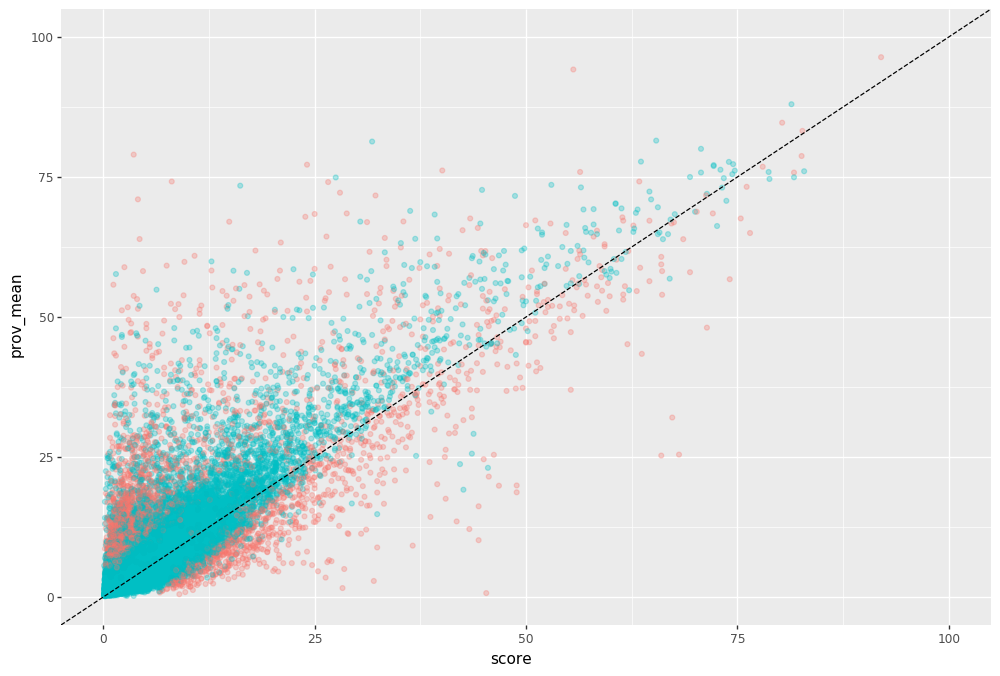

<ggplot: (8773053746641)>

In [141]:
(ggplot(final_op10_dataset,
        aes(x = 'score',
            y = 'prov_mean',
            color = 'outlier')) +
 geom_point(size = 1.5, show_legend=False, alpha = 0.3) +
 xlim(0,100) +
 ylim(0,100) +
 labs(fill = 'Predicted Anomaly', color = 'Predicted Anomaly') +
 scale_color_manual(values = ["#00BFC4", "#F8766D"]) +
 geom_abline(intercept = 0, slope = 1, linetype = 'dashed')
)


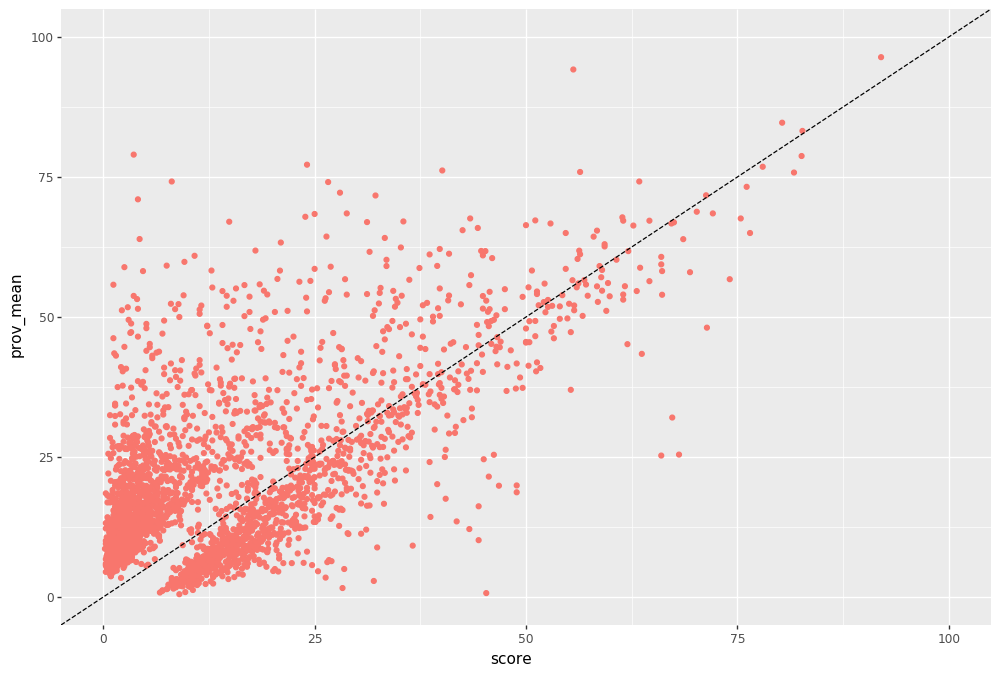

<ggplot: (8773037381617)>

In [143]:
(ggplot(final_op10_dataset[final_op10_dataset['outlier'] == True],
        aes(x = 'score',
            y = 'prov_mean',
            color = 'outlier')) +
 geom_point(size = 1.5, show_legend=False) +
 xlim(0,100) +
 ylim(0,100) +
 labs(fill = 'Predicted Anomaly', color = 'Predicted Anomaly') +
 scale_color_manual(values = ["#F8766D"]) +
 geom_abline(intercept = 0, slope = 1, linetype = 'dashed')
)

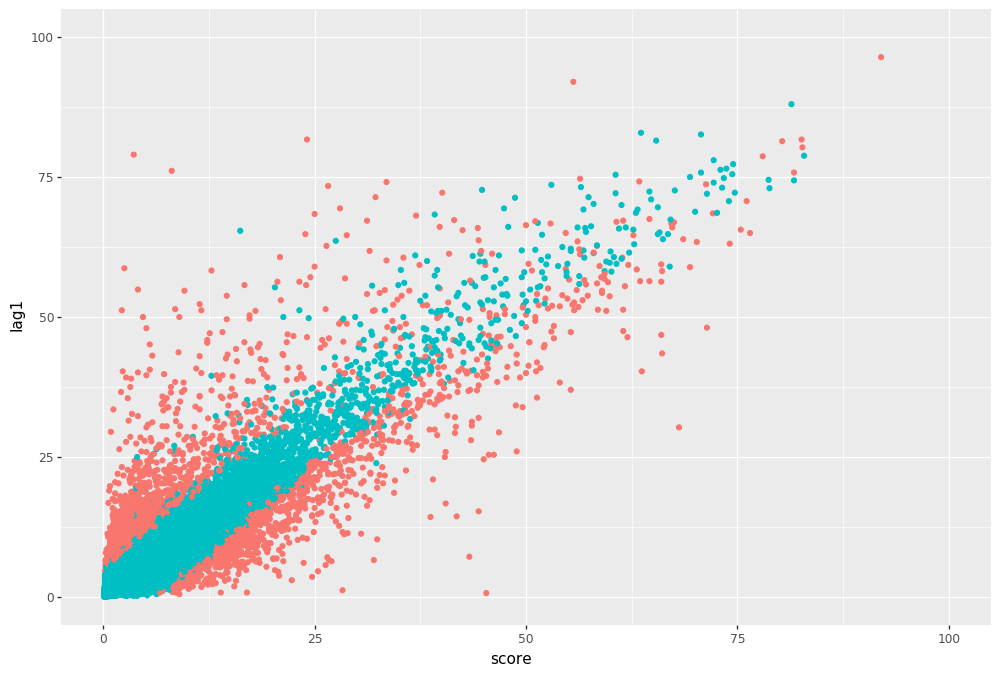

<ggplot: (8773032496529)>

In [154]:
(ggplot(final_op10_dataset,
        aes(x = 'score',
            y = 'lag1',
            color = 'outlier')) +
 geom_point(size = 1.5, 
            show_legend=False) +
 xlim(0,100) +
 ylim(0,100) +
 labs(fill = 'Predicted Anomaly', color = 'Predicted Anomaly') +
 scale_color_manual(values = ["#00BFC4", "#F8766D"])
)

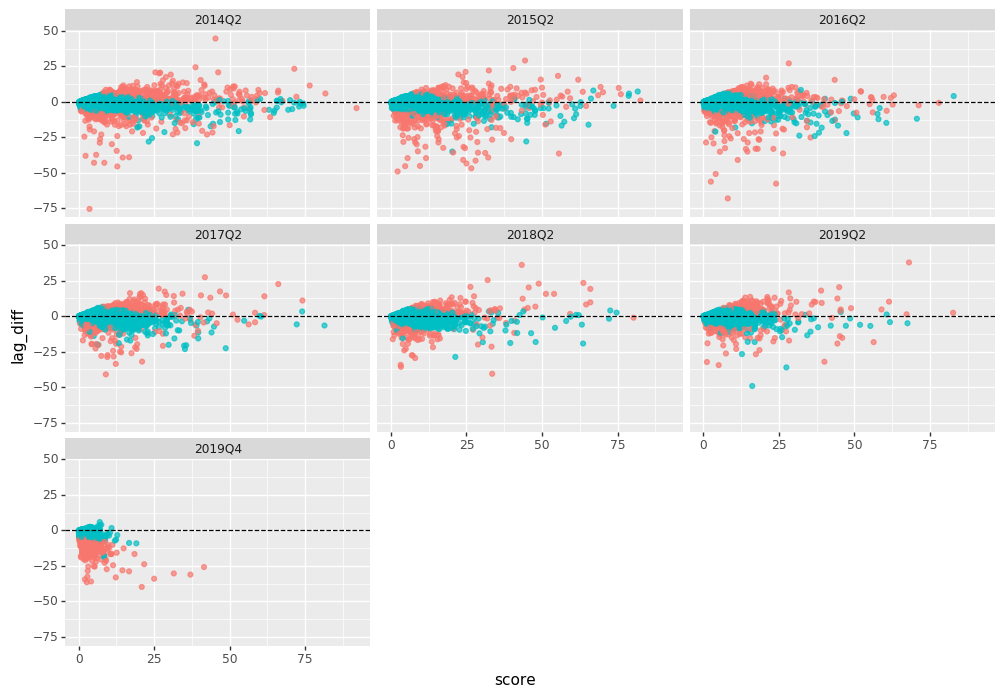

<ggplot: (8773055377705)>

In [190]:
(ggplot(final_op10_dataset,
        aes(x = 'score',
            y = 'lag_diff',
            color = 'outlier')) +
 geom_point(size = 1.5, show_legend=False, alpha = 0.7) +
 geom_hline(yintercept = 0, linetype = 'dashed') +
 labs(fill = 'Predicted Anomaly', color = 'Predicted Anomaly') +
 scale_color_manual(values = ["#00BFC4", "#F8766D"]) +
 facet_wrap('~y_quarter')
)

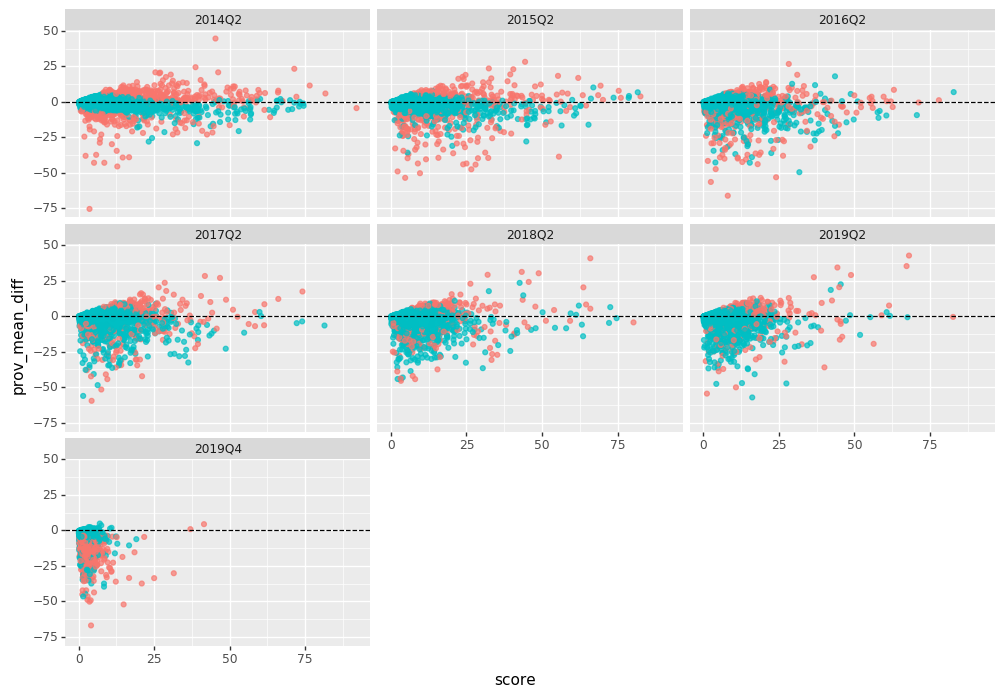

<ggplot: (8773031043165)>

In [189]:
(ggplot(final_op10_dataset,
        aes(x = 'score',
            y = 'prov_mean_diff',
            color = 'outlier')) +
 geom_point(size = 1.5, show_legend=False, alpha = 0.7) +
 labs(fill = 'Predicted Anomaly', color = 'Predicted Anomaly') +
 scale_color_manual(values = ["#00BFC4", "#F8766D"]) +
 geom_hline(yintercept = 0, linetype = 'dashed') +
 facet_wrap('~y_quarter')
)

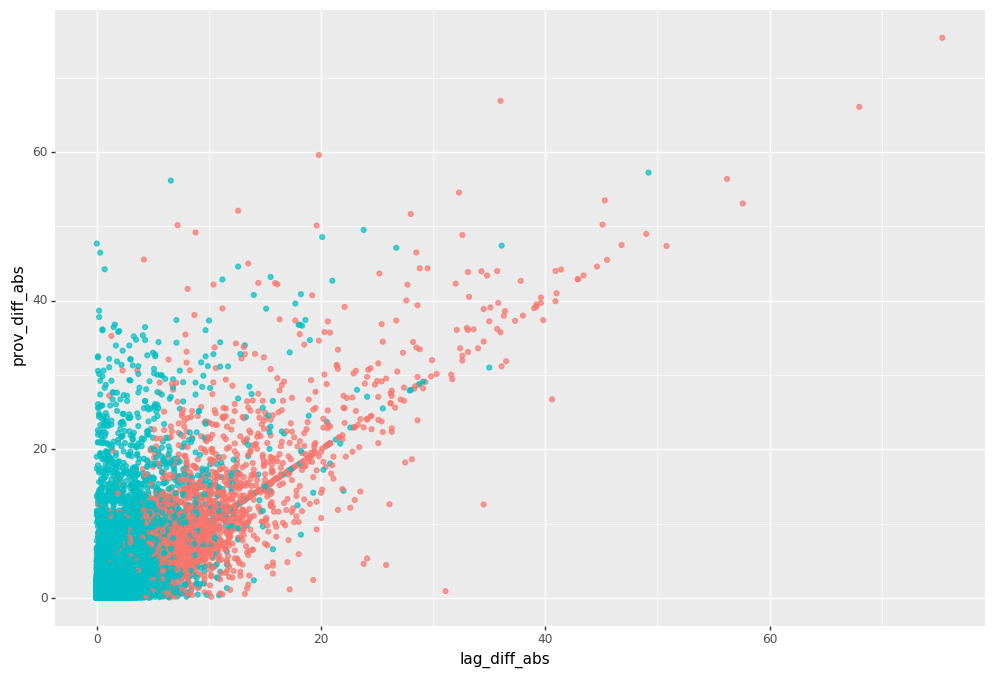

<ggplot: (8773032532489)>

In [184]:
(ggplot(final_op10_dataset,
        aes(x = 'lag_diff_abs',
            y = 'prov_diff_abs',
            color = 'outlier')) +
 geom_point(size = 1.5, show_legend=False, alpha = 0.7) +
 labs(fill = 'Predicted Anomaly', color = 'Predicted Anomaly') +
 scale_color_manual(values = ["#00BFC4", "#F8766D"])
)

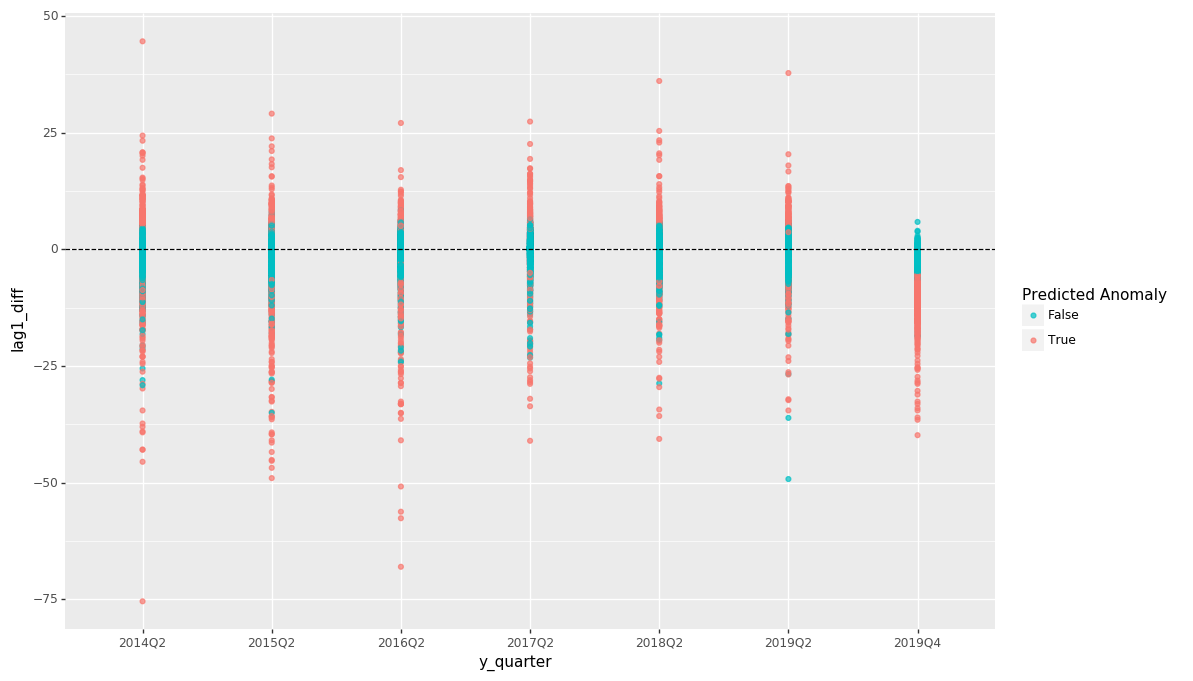

<ggplot: (8773037521629)>

In [151]:
(ggplot(final_op10_dataset,
        aes(x = 'y_quarter',
            y = 'lag1_diff',
            color = 'outlier')) +
 geom_point(size = 1.5, alpha = 0.7) +
 geom_hline(yintercept = 0, linetype = 'dashed') +
 labs(color = 'Predicted Anomaly') +
 scale_color_manual(values = ["#00BFC4", "#F8766D"])
)

In [152]:
final_op10_dataset[final_op10_dataset['outlier'] == False]\
    .sort_values(by = 'prov_mean_diff', ascending = False)

,provider_id,score,lag1,lag2,year,quarter,lag_diff,prov_mean,prov_mean_diff,outlier,predicted_score,diff,lag1_diff,y_quarter
11209,190098,42.6,41.8,14.4,2018,2,0.8,19.160000,23.440000,False,42.692101,-0.092101,0.8,2018Q2
11210,190098,45.5,42.6,41.8,2019,2,2.9,23.066667,22.433333,False,43.056305,2.443695,2.9,2019Q2
25685,450834,42.2,48.9,26.0,2019,2,-6.7,23.733333,18.466667,False,42.731567,-0.531567,-6.7,2019Q2
24697,450200,43.6,44.4,15.3,2016,2,-0.8,25.600000,18.000000,False,44.400146,-0.800146,-0.8,2016Q2
4780,100105,32.4,29.0,14.1,2018,2,3.4,14.800000,17.600000,False,28.318026,4.081974,3.4,2018Q2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13925,241325,4.3,4.3,24.1,2019,2,0.0,52.000000,-47.700000,False,4.585354,-0.285354,0.0,2019Q2
20936,370215,6.3,26.4,62.7,2017,2,-20.1,54.875000,-48.575000,False,10.797386,-4.497386,-20.1,2017Q2
7154,140100,31.8,55.6,92.0,2016,2,-23.8,81.333333,-49.533333,False,32.030975,-0.230975,-23.8,2016Q2
9850,170120,1.5,8.1,76.1,2017,2,-6.6,57.675000,-56.175000,False,3.819500,-2.319500,-6.6,2017Q2


In [153]:
[display(final_op10_dataset[final_op10_dataset['providerId'] == n]) for n in june_22_outliers]

NameError: name 'june_22_outliers' is not defined

In [106]:
final_op10_dataset

,providerId,score,y_quarter,lag1,lag2,year,quarter,outlier
0,10001,62,2017Q3,62.0,62.0,2017,3,False
1,10001,61,2017Q4,62.0,62.0,2017,4,False
2,10001,60,2018Q1,61.0,62.0,2018,1,False
3,10001,61,2018Q2,60.0,61.0,2018,2,False
4,10001,62,2018Q3,61.0,60.0,2018,3,False
...,...,...,...,...,...,...,...,...
42290,670128,66,2021Q3,72.0,87.0,2021,3,False
42291,670131,91,2020Q3,91.0,91.0,2020,3,False
42292,670131,87,2020Q4,91.0,91.0,2020,4,False
42293,670131,86,2021Q1,87.0,91.0,2021,1,True


In [160]:
final_op10_dataset.query('(prov_mean_diff <1) & (lag1_diff <1)')

,provider_id,score,lag1,lag2,year,quarter,lag_diff,prov_mean,prov_mean_diff,outlier,predicted_score,diff,lag1_diff,y_quarter
2,10001,6.4,6.5,4.6,2015,2,-0.1,5.550000,0.850000,False,5.982095,0.417905,-0.1,2015Q2
4,10001,6.5,9.0,6.4,2017,2,-2.5,6.625000,-0.125000,False,7.982599,-1.482599,-2.5,2017Q2
6,10001,7.2,8.0,6.5,2019,2,-0.8,6.833333,0.366667,False,7.308410,-0.108410,-0.8,2019Q2
7,10001,1.1,7.2,8.0,2019,4,-6.1,6.885714,-5.785714,True,6.860431,-5.760431,-6.1,2019Q4
9,10005,11.9,12.4,NaN,2014,2,-0.5,12.400000,-0.500000,False,11.167706,0.732294,-0.5,2014Q2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29086,670119,63.2,69.2,NaN,2018,2,-6.0,69.200000,-6.000000,False,60.185501,3.014499,-6.0,2018Q2
29090,670120,1.6,7.5,6.6,2019,4,-5.9,5.266667,-3.666667,True,6.798064,-5.198064,-5.9,2019Q4
29092,670122,12.6,16.1,NaN,2019,2,-3.5,16.100000,-3.500000,False,14.525786,-1.925786,-3.5,2019Q2
29093,670122,8.7,12.6,16.1,2019,4,-3.9,14.350000,-5.650000,False,11.732296,-3.032296,-3.9,2019Q4


In [180]:
final_op10_dataset.query('(prov_diff_abs >5) & (lag_diff_abs >5)')['outlier'].value_counts()

True     2062
False     794
Name: outlier, dtype: int64

In [169]:
final_op10_dataset.query('prov_mean_diff <0.001 & lag_diff <0.001 & outlier == True')

,provider_id,score,lag1,lag2,year,quarter,lag_diff,prov_mean,prov_mean_diff,outlier,predicted_score,diff,lag1_diff,y_quarter


In [107]:
final_op10_dataset.drop(columns = ['outlier']).drop_duplicates()

,providerId,score,y_quarter,lag1,lag2,year,quarter
0,10001,62,2017Q3,62.0,62.0,2017,3
1,10001,61,2017Q4,62.0,62.0,2017,4
2,10001,60,2018Q1,61.0,62.0,2018,1
3,10001,61,2018Q2,60.0,61.0,2018,2
4,10001,62,2018Q3,61.0,60.0,2018,3
...,...,...,...,...,...,...,...
42290,670128,66,2021Q3,72.0,87.0,2021,3
42291,670131,91,2020Q3,91.0,91.0,2020,3
42292,670131,87,2020Q4,91.0,91.0,2020,4
42293,670131,86,2021Q1,87.0,91.0,2021,1


In [82]:
xgb_results = pd.read_csv('../xgboost-regression/prediction_res.csv')
xgb_results

,score,provider_id,lag1,lag2,year,quarter,prediction,delta,outlier
0,69,10001,69.0,69.0,2015,1,74,5,False
1,77,10001,69.0,69.0,2015,2,75,-2,False
2,83,10001,77.0,69.0,2015,3,79,-4,False
3,76,10005,76.0,76.0,2014,1,79,3,False
4,83,10005,76.0,76.0,2014,2,79,-4,False
...,...,...,...,...,...,...,...,...,...
33952,54,670124,59.0,64.0,2019,4,59,5,False
33953,69,670124,54.0,59.0,2020,3,61,-8,False
33954,100,670124,69.0,54.0,2020,4,75,-25,False
33955,83,670124,100.0,69.0,2021,1,86,3,False


In [86]:
sum((final_op10_dataset['outlier'] == True) & (xgb_results['outlier'] == True))

0